Binôme: Sohaib Errabii, Reda Chaguer

# IF240 - Apprentissage et deep learning

## Assignment 1: K-Means, Naive Bayes, SVMs and CNNs

### Objectives 

The objective of this assignment is to apply different classification algorithms for the application of handwritten digits recognition.

# PART 0 - Preparing the dataset

In this practice, you will experiment with the well-known MNIST dataset

In [62]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import MNISTtools

Let us first load and normalize MNIST testing and training data. This dataset is made of 60000 grayscale images of size 28$\times$28

In [2]:
x_train, y_train = MNISTtools.load(dataset='training')
x_test, y_test = MNISTtools.load(dataset='testing')

To reduce the computation cost, we only select a small part of $n$ images for further analysis. _You might modify this value later to visualise its influence on the results._

In [4]:
n = 5000
x_train = x_train[:,1:n+1]
y_train = y_train[1:n+1]

## Question 1

How many training and testing images compose the dataset? What are the dimensions of the data samples?

- Training DataSet is composed of n (= 5000) images
- Testing DataSet is composed of 10000 images
- Each sample is of dimension 784 (vector)

In [5]:
print(x_train.shape)
print(x_test.shape)

(784, 5000)
(784, 10000)


To visualize the images, the vectors must be reshaped to a grayscale square image.  

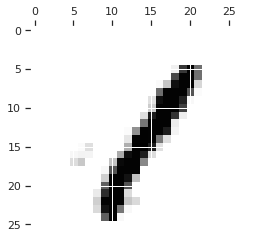

the label of image 200 is 1


In [109]:
x_test_im = x_test.reshape((28, 28, 1, -1))

x_train_im = x_train.reshape((28, 28, 1, -1))

# let us show image number 200 and its label
MNISTtools.show(x_train_im[:, :, 0, 200])
print("the label of image 200 is", y_train[200])

# PART 1 - K-Means

In this first part you must group the testing set into 10 clusters using the K-Means algorithm. 
You must observe the clustering result by visualizing as images the computed centroids and by checking if each found cluster corresponds to one label from the ground truth given by `y_test`. In other words, check to which cluster is assigned each data point, as in a classification problem. Analyse the results. 

Be careful: the index of the clusters you find (named `pred_labels` here) does not mandatorily correspond to the digit value (initial label `y_test`). One way to find which label corresponds to each cluster is to visualise the centroid image, or to compute the mode of each class in the ground truth, for example using the following code:

```
from scipy.stats import mode
real_pred_labels = np.zeros_like(pred_labels)
real_pred_centers = np.zeros_like(pred_centers)
for i in range(10):
    indices = np.where(pred_labels == i)[0]
    real_value = mode(y_test[indices])[0]
    real_pred_labels[indices] = real_value
    real_pred_centers[real_value] = pred_centers[i]
```

In [52]:
# Transpose data, necessary for K-Means, Naive Bayes and SVM with sklearn
x_test_t =  np.transpose(x_test)
x_train_t =  np.transpose(x_train)

## Question 2

Implement K-Means. Add comments to your code as necessary to make it more explicit

In [53]:
class Kmeans(object):
    
    def __init__(self):
        self.centroids = None
        self.labels = None
        
    # Function: getDistance
    # -------------
    # Returns the distance between two points
    def getDistance(self, point1, point2):
        return np.linalg.norm(point1-point2)


    # Function: getRandomCentroids
    # -------------
    # Initialize centroids by choosing randomly k points from the dataset
    def getRandomCentroids(self, dataSet, numClusters):
        numPoints, _ = dataSet.shape
        centroids = dataSet[np.random.randint(numPoints, size =  numClusters), :]
        return centroids


    # Function: shouldStop
    # -------------
    # Returns True or False if k-means if the maximum number of iterations is reached 
    # or if the centroids do not change anymore
    def shouldStop(self, oldCentroids, centroids, iterations, MAX_ITERATIONS, UNTIL_CONV=False):
        if ((not UNTIL_CONV) and iterations > MAX_ITERATIONS): 
            return True
        return np.array_equal(oldCentroids, centroids)


    # Function: getLabels
    # -------------
    # Returns the label for each point in the dataSet. The label is the one of the closest centroid
    def getLabels(self, dataSet, centroids):
        numPoints, _ = dataSet.shape
        labels = np.zeros(numPoints)

        for i in range(numPoints) : 
            labels[i] = np.argmin([self.getDistance(dataSet[i], c) for c in centroids])

        return labels


    # Function: getCentroids
    # -------------
    # Returns the centroids of the clusters. Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    def getCentroids(self, dataSet, labels, k):
        newCentroids = []
        uniqueCentroids = np.unique(labels)

        for c in uniqueCentroids:
            indexs = np.where(labels == c)
            newCentroid = np.mean([dataSet[i] for i in indexs], axis=1)
            newCentroids.append(newCentroid[0])

        resulted_k = len(newCentroids)
        if (resulted_k < k):
            numPoints, _ = dataSet.shape
            np.append(newCentroids, dataSet[np.random.randint(numPoints, size =  k - resulted_k), :])

        return np.array(newCentroids)


    # Function: fit
    # -------------
    # Runs KMeans clustering
    def fit(self, dataSet, k, MAX_ITERATIONS=5, UNTIL_CONV=False):

        centroids = self.getRandomCentroids(dataSet, k)
        iterations = 0
        oldCentroids = None

        while not self.shouldStop(oldCentroids, centroids, iterations, MAX_ITERATIONS, UNTIL_CONV):
            oldCentroids = centroids
            iterations += 1
            labels = self.getLabels(dataSet, centroids)
            centroids = self.getCentroids(dataSet, labels, k)
        
        self.centroids = centroids
        self.labels = labels
        return centroids, labels
    
    def predict(self, x):
        min_dis = float('inf')
        for label in range(10):
            distance = np.linalg.norm(self.centroids[label] - x)
            if distance < min_dis:
                min_dis = distance
                predicted_label = label
        return predicted_label
    
    def evaluate_accuracy(self, x, y, centroids_labels, ISTEST=False):
        total_acc = 0
        for digit in range(10):
            tab = np.zeros(len(self.centroids))
            for i in range(y.size):
                if(y[i] == digit):
                    if (ISTEST):
                        tab[centroids_labels[self.predict(x[i])]] += 1
                    else:
                        tab[centroids_labels[int(self.labels[i])]] += 1
            digit_acc = max(tab) / sum(tab) * 100.0
            total_acc += digit_acc
        total_acc /= 10

        print("KMeans Accuracy " + str(total_acc))
        return total_acc

## Question 3

Analyse the results

We create an instance of the object `Kmeans` and then we call the method `fit` unti convergence
is reached; centroids no longer change.
Since we are interested in classifying the images of digits `0-9`, we chose `k = 10`, hoping to associate
each cluster with a certain digit.

However, the results below show that the obtained clusters are not exactly separated according to the digits.

The images of digit `5` in particular are very hard to separate from other digits,
although sometimes (as it depends on the initial value of centroids) to obtain a centroid with label `5`. The actual cluster
still contains a mix of images of different digits. This is probably due to the fact that the images of digit `5` are rather
close (in terms of the distance used) to most of the images (setting a line of pixels can change 5 to 9 or 6 for example).

The accuracies obtained in multiple runs range between $60\%$ to $70\%$

As shown below, we also tried to use various values for the number of clusters $k$.
The accuracy obtained seems to fluctuate around $65\%$.

In [54]:
KM = Kmeans()
centroids, labels = KM.fit(x_train_t, 10, UNTIL_CONV=True)

In [46]:
def show_centroids(centroids):
    for i in range(len(centroids)):
        result_imag = centroids[i].T.reshape((28, 28, 1, -1))
        MNISTtools.show(result_imag[:, :, 0, 0])

In [47]:
def pourcentage_train_tab(x_train, y_train, centroids, labels, SHOW=True):
    tab = np.zeros((len(centroids), len(centroids)))
    for i in range(y_train.size):
        tab[y_train[i], int(labels[i])] += 1
    row_sums = tab.sum(axis=1)
    row_max_ind = tab.argmax(axis=0)
    tab = tab / row_sums[:np.newaxis] * 100
    row_sums = tab.sum(axis=1)
    if (SHOW):
        plt.imshow(tab)
        plt.colorbar()
    return row_max_ind

In [48]:
def pourcentage_test_tab(x_test, y_test, KM_instance, centroids, SHOW=True):
    labels = np.array([KM_instance.predict(x) for x in x_test])
    tab = np.zeros((len(centroids), len(centroids)))
    for i in range(y_test.size):
        tab[y_test[i], int(labels[i])] += 1
    row_sums = tab.sum(axis=1)
    row_max_ind = tab.argmax(axis=0)
    tab = tab / row_sums[:np.newaxis] * 100
    row_sums = tab.sum(axis=1)
    if (SHOW):
        plt.imshow(tab)
        plt.colorbar()
    return row_max_ind

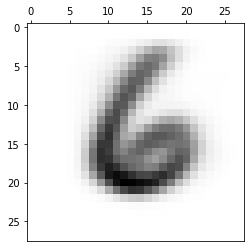

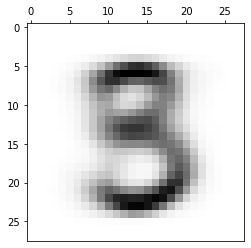

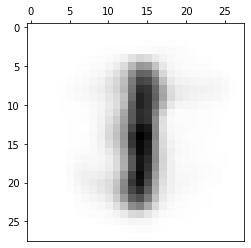

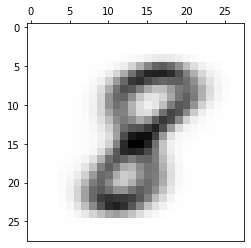

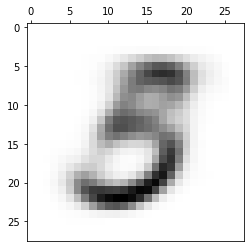

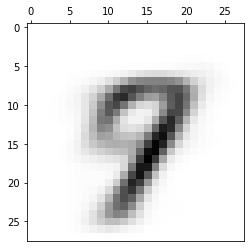

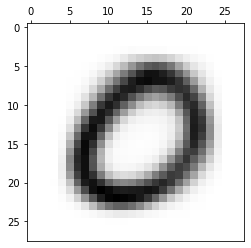

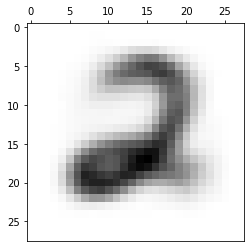

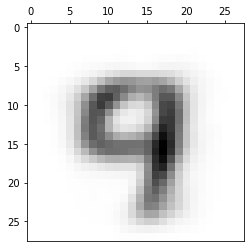

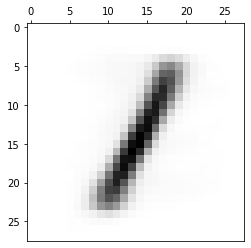

In [55]:
show_centroids(centroids)

[6 3 1 8 3 7 0 2 4 1]


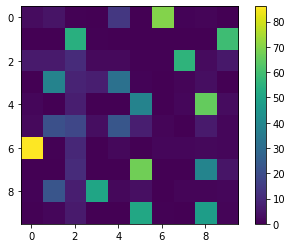

In [56]:
centroids_labels = pourcentage_train_tab(x_train, y_train, centroids, labels)
print(centroids_labels)

[6 3 1 8 3 7 0 2 4 1]


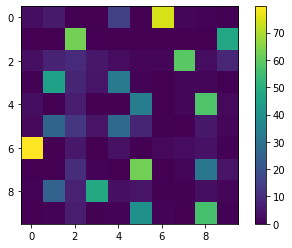

In [57]:
test_centroids_labels = pourcentage_test_tab(x_test_t, y_test, KM, centroids)
print(test_centroids_labels)

In [58]:
print("train accuracy:")
KM.evaluate_accuracy(x_train_t, y_train, centroids_labels)
print("test accuracy:")
_ = KM.evaluate_accuracy(x_test_t, y_test, centroids_labels, True)

train accuracy:
KMeans Accuracy 66.09074947422909
test accuracy:
KMeans Accuracy 67.45744066616189


KMeans Accuracy 61.66602408916335
KMeans Accuracy 62.63339592351252
KMeans Accuracy 66.81094088204031
KMeans Accuracy 66.40498491735922
KMeans Accuracy 68.45594755419201
KMeans Accuracy 61.52033175722638


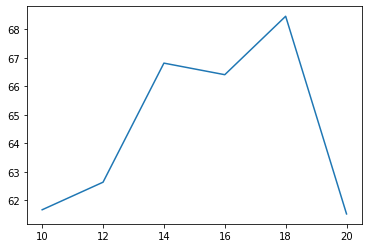

In [61]:
KM = Kmeans()
X = np.arange(10, 21, 2)
Y = []
for i in X:
    centroids, labels = KM.fit(x_train_t, i, 16) 
    centroids_labels = pourcentage_train_tab(x_train, y_train, centroids, labels, False)
    Y.append(KM.evaluate_accuracy(x_test_t, y_test, centroids_labels, True))

plt.plot(X, Y)
plt.show()

# PART 2 - Naive Bayes
Apply Naive Bayes classification to the digits classification problem. Train the model on the training dataset and evaluate on the testing set. Analyse your results

## Question 4

Implement Naive Bayes. Add comments to your code as necessary to make it more explicit

In [65]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 

# set up the MultinomialNB classifier and train it
classifierNB = MultinomialNB()
classifierNB.fit(x_train_t, y_train)

# prediction
y_pred = classifierNB.predict(x_test_t)

## Question 5

Analyse the results obtained on the testing dataset 

For Naive Bayes method, we used the Class MultinomialNB. The accuracy obtained
on the test dataset is around $83\%$.

The confusion matrix below, shows that for Naive Bayes, the digit $4$
is mostly confused with digit $9$. $5$ mostly confused with $3$ and $8$.
Meanwhile the digit $0$ is the least confused with other digits, with the highest precision of $93\%$.

Accuracy : 0.8327

Ou encore avec plus de détails:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       980
           1       0.92      0.93      0.92      1135
           2       0.89      0.82      0.85      1032
           3       0.79      0.85      0.82      1010
           4       0.81      0.73      0.77       982
           5       0.85      0.67      0.75       892
           6       0.90      0.89      0.89       958
           7       0.94      0.83      0.88      1028
           8       0.68      0.79      0.73       974
           9       0.68      0.86      0.76      1009

    accuracy                           0.83     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.83      0.83     10000

Confusion matrix using MultinomialNB:


<AxesSubplot:>

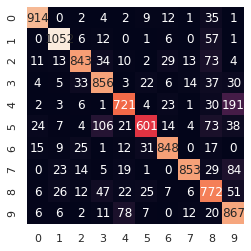

In [66]:
accuracy = accuracy_score(y_test, y_pred) 
print("Accuracy : {0:.4f}".format(accuracy))

print("\nOu encore avec plus de détails:")
print(classification_report(y_test, y_pred))

print("Confusion matrix using MultinomialNB:")
cmNB = confusion_matrix(y_test, y_pred)

#for visualisation of the confusion matrix
import seaborn as sns; sns.set()  # for plot styling
sns.heatmap(cmNB, square=True, annot=True, fmt='d', cbar=False, xticklabels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']\
           ,yticklabels =  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# PART 3 - SVM
Apply SVM classification with linear and polynomial/gaussian kernels to the digits classification problem. Train the models on the training dataset and evaluate on the testing set. Analyse your results

## Question 6

Implement SVM classification with linear and polynomial/gaussian kernels. Add comments to your code as necessary to make it more explicit

In [73]:
from sklearn import svm
from itertools import product as prd

C_set = [10**exp for exp in range(-3, 3)]

In [74]:
class SVM(object):
    
    def __init__(self, C_set, kernel_set):
        self.instance = svm.SVC()
        self.optimal_params = None
        self.max_acc = 0.
        self.svm_params = [C_set, kernel_set, ['auto', 'scale']]

    def searchOptimalParams(self, x_train, y_train, x_valid, y_valid):
        for C_val, k_type, g_type in prd(*self.svm_params):
            self.instance.set_params(**{'C':C_val, 'kernel':k_type, 'gamma': g_type})
            self.instance.fit(x_train, y_train)

            curr_acc = self.instance.score(x_valid, y_valid)

            if (curr_acc > self.max_acc):
                self.max_acc = curr_acc
                self.optimal_params = [C_val, k_type, g_type]
                
    def showOptimalParams(self):
         print("Optimal Params :", str(self.optimal_params), "with an accuracy of"+ str(self.max_acc))
    
    def fitOptimalParams(self, x_train, y_train):
        self.instance.set_params(**{'C':self.optimal_params[0], 'kernel':self.optimal_params[1], 'gamma': self.optimal_params[2]})
        self.instance.fit(x_train, y_train)
    
    def getInstance(self):
        return self.instance

## Question 7

Analyse the results obtained on the testing dataset

For this implementation of SVM classifier, we tried the linear, polynomial and rbf kernels.

For the $poly$ and $rbf$ kernels, we have properly separated 20% of the training set into a validation set
in order to find the optimal hyper-parameters ($C$, $gamma$).

As shown below, for the linear kernel (whose hyper-parameters weren't modified) we obtained a test accuracy of $91\%$.

For the polynomial kernel, we found that $C = 0.001$ is the optimal value (for the validation set). This allowed us
to obtain an accuracy on the test set of $93\%$, a small improvement compared to linear kernel.

Finally, for the guassian kernel, we found that $C = 10$, $gamma = scale$ are the optimal values. The test accuracy
obtained is around $95\%$, yet another improvement compared to polynomial and linear kernels.

In [72]:
linear_svm = svm.SVC(kernel='linear')
linear_svm.fit(x_train_t, y_train)
accuracy = linear_svm.score(x_test_t, y_test)
print("Test accuracy with linear kernel: {0:.4f}".format(accuracy))

# split train set in order to search for optimal hyperparams
indices = np.random.permutation(n)
x_train_1 = x_train_t[indices[:int(0.8 * n)], :]
y_train_1 = y_train[indices[:int(0.8 * n)]]
x_valid = x_train_t[indices[int(0.8 * n):], :]
y_valid = y_train[indices[int(0.8 * n):]]

# search params for polynomial kernel
svm_poly = SVM(C_set, ['poly'])
svm_poly.searchOptimalParams(x_train_1, y_train_1, x_valid, y_valid)
print("Optimal params for poly kernel:", svm_poly.optimal_params)
svm_poly.fitOptimalParams(x_train_1, y_train_1)
accuracy = svm_poly.instance.score(x_test_t, y_test)
print("Test accuracy with polynomial kernel: {0:.4f}".format(accuracy))

# search params for rbf kernel
svm_gauss = SVM(C_set, ['rbf'])
svm_gauss.searchOptimalParams(x_train_1, y_train_1, x_valid, y_valid)
print("Optimal params for rbf kernel:", svm_gauss.optimal_params)
svm_gauss.fitOptimalParams(x_train_1, y_train_1)
accuracy = svm_gauss.instance.score(x_test_t, y_test)
print("Test accuracy with gaussian kernel: {0:.4f}".format(accuracy))

Test accuracy with linear kernel: 0.9104
Optimal params for poly kernel: [0.001, 'poly', 'auto']
Test accuracy with polynomial kernel: 0.9381
Optimal params for rbf kernel: [10, 'rbf', 'scale']
Test accuracy with gaussian kernel: 0.9524


# PART 4 - CNNs

CNNs are specific artificial neural networks composed of *convolutional* layers, *maxpooling* operations, and
*fully connected* layers.
- Convolutional layers are like typical layers where the weight matrix has a specific structure that is relevant for signals and images.  
They take as input $N$ images and produce as output $C$ images (called *feature maps* or *channels*).   
They are parameterized by a collection of coeficients that defines a filter bank. Each filter performs a weighted average of its inputs within local sliding windows of size $K \times K$  (pixels) where $K$ is a hyperparameter (a small odd number: 3, 5, 7, 9).  
As for classical layers in neural networks, each feature map is next processed by an activation function such as  ReLU.  
    
- Maxpooling operations reduce the dimensions of the feature maps by picking the maximum value within local but non-overlapping sliding windows of size $L \times L$ (pixels) where $L$ is another hyper-parameter (usually 2). Maxpooling does not introduce new parameters to be learned.  
  
- Fully connected layers are standard layers where the weight matrix does not have a specific structure: each of the $N$ output units is connected to each of the $M$ input units.

## Question 8

PyTorch expects that the input of a convolutional layer is stored in the following format:
  $$
  \texttt{Batch size} \times \texttt{Number of input channels} \times \texttt{Image height} \times \texttt{Image width}
  $$
  
The number of input channels in our case is 1 because MNIST is composed of grayscale images. It would have been 3 if the images were in RGB color.
In deeper layers, the number of input channels will be the number of feature maps coming from the previous layer.

Reorganise the tensors `x_train_im` and `x_test_im` accordingly.
Hint:
  Reshape them first with shape $\texttt{(28, 28, 1, 60000)}$ and $\texttt{(28, 28, 1, 10000)}$
  respectively and then use `np.moveaxis`.

In [75]:
x_train_im = np.moveaxis(x_train_im, [0, 1, 2], [-1, -2, -3])
x_test_im = np.moveaxis(x_test_im, [0, 1, 2], [-1, -2, -3])

Let us also normalize MNIST testing and training data.

In [77]:
def normalize_MNIST_images(x):
    return 2 * x.astype(np.float32) / 255. - 1
x_train_im = normalize_MNIST_images(x_train_im)
x_test_im = normalize_MNIST_images(x_test_im)

and finally wrap all the data into torch Tensors

In [93]:
x_train_torch = torch.from_numpy(x_train_im)
y_train_torch = torch.from_numpy(y_train)
x_test_torch = torch.from_numpy(x_test_im)
y_test_torch = torch.from_numpy(y_test)

## Question 9

Neural networks can be constructed using the `torch.nn` package, which relies on `autograd` differentiation tools.
This package provides an implementation of CNNs as follows:

* Convolutional layers can be created as `nn.Conv2d(N, C, K)`.
  For input images of size $W \times H$, without padding the output feature maps have size $[W-K+1] \times [H-K+1]$.
* In PyTorch, maxpooling is implemented like any other non-linear function (such as
  `ReLU` or `softmax`).
  For input images of size $W \times H$, the output feature maps
  have size $\lceil W/L \rceil \times \lceil H/L \rceil$.
* A fully connected layer can be created as `nn.Linear(M, N)`.

Our LeNet network will be composed successively of
   1. a convolutional layer (i) connecting the input image to 6
    feature maps with $5 \times 5$ convolutions ($K = 5$) and followed
    by ReLU and maxpooling (ii) ($L=2$),
   2. a convolutional layer (iii) connecting the 6 input channels to 16
    output channels with $5 \times 5$ convolutions and followed
    by ReLU and maxpooling (iv) ($L=2$),
   3. a fully-connected layer connecting $16$ feature maps
    to $120$ output units and followed by ReLU,
   4. a fully-connected layer connecting $120$ inputs
    to $84$ output units and followed by ReLU,
   5. a final linear layer connecting $84$ inputs
    to $10$ linear outputs (one for each of our digits).

Determine the size of the feature maps after each convolution and maxpooling operation i.e. at points (i)-(iv) processing steps. 

Lets consider one sample of size $28 \times 28$.

$(i)$ Applying $6$ filters of size $5 \times 5$ with no padding and a stride of one would give us $6$ feature maps of size $24 \times 24$ (taking into account the bias, this corresponds to $156$ parameters). 

$(ii)$ Following the maxpooling, each of the 6 feature maps will be reduced to $12 \times 12$.

$(iii)$ Considering a stride of one and no padding, we will obtain $16$ feature map each of size $8 \times 8$ (this layer has $16\times(5\times 5\times 6) + 16 =  2416$ parameters).

$(iv)$ Following the maxpooling, each of the 16 feature maps will be reduced to $4 \times 4$.

## Question 10

Analyse and complete the following code initializing our LeNet network. 

Note that you just have to define the forward function, and the backward function (where gradients are computed) will be automatically defined for you using `autograd`.
You can use any of the Torch tensor operations in the forward function.
For more details, please refer to https://pytorch.org/docs/stable/nn.html

In [94]:
# The neural networks class
class LeNet(nn.Module):

    # define our network structure
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6 , 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # define one forward pass through the network
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    # helper function to understand the dimensions
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        return np.prod(size)

net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Question 11

Run the following and interpret the results. What are the learnable parameters?  Are gradients going to be tracked for all parameters?

In [81]:
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)  

conv1.weight torch.Size([6, 1, 5, 5]) True
conv1.bias torch.Size([6]) True
conv2.weight torch.Size([16, 6, 5, 5]) True
conv2.bias torch.Size([16]) True
fc1.weight torch.Size([120, 256]) True
fc1.bias torch.Size([120]) True
fc2.weight torch.Size([84, 120]) True
fc2.bias torch.Size([84]) True
fc3.weight torch.Size([10, 84]) True
fc3.bias torch.Size([10]) True


This shows the learnable parameters (weights and biases) of each layer.

We can see that the gradients are going to be tracked for all (learnable) parameters which is necessary
for the backpropagation.

This also confirms the estimated number of learnable parameters in the answer to question $9$.
For example, the second convolutional layer had $16\times5\times5\times6 + 16 = 2416$ parameters (weights and biases).

### Running a foward pass

To run a forward pass of your initial network over your testing set, simply run the following code. 

Note that `with torch.no_grad()` is used to avoid tracking for
gradient during testing and then save some computation time
(refer to https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad).

In [82]:
with torch.no_grad():
    pred = net(x_test_torch) # equivalent to pred = net.forward(x_test_torch)

## Question 12

Run the following and interpret the result

In [83]:
_, pred_labels = pred.max(1)
print(100 * (y_test_torch == pred_labels).float().mean())

tensor(10.2600)


`pred.max(1)` returns the index (between 0 to 9) having the maximum value for each image of the test set.
This index can be interpreted as the most likely digit represented by the image. The other option, would have
been to use a `softmax` activation to obtain a probability distribution over the predicted outputs.

The initial values given to the parameters of the network allowed us to obtain a test accuracy of $\sim 10\%$.

## Question 13

We will use (Mini-Batch) Stochastic Gradient Descent (SGD) with momentum, and cross-entropy as the loss.
Complete the following function.

For more details, refer to
https://pytorch.org/docs/stable/nn.html and
https://pytorch.org/docs/stable/optim.html.

Note that PyTorch's `CrossEntropyLoss` is already the composition of a softmax activation with the standard cross-entropy loss.

In [119]:
# T: number of epochs
# B: minibatch size, 
# gamma: step size,
# rho: momentum.
def backprop_deep(x_train, y_train, net, T, B=100, gamma=.001, rho=.9):
    N = x_train.size()[0]        # Training set size
    NB = N // B   # Number of minibatches
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=gamma, momentum=rho)
    
    loss_values = []
    for epoch in range(T):
        running_loss = 0.0
        test_loss = 0.0
        shuffled_indices = np.random.permutation(range(N))
        for k in range(NB):
            # Extract k-th minibatch from xtrain and ltrain
            minibatch_indices = shuffled_indices[B*k:min(B*(k+1), N)]
            inputs = x_train[minibatch_indices, ...]
            labels = y_train[minibatch_indices, ...]
            
            # Initialize the gradients to zero
            optimizer.zero_grad()

            # Forward propogation
            outputs = net(inputs) 

            # Error evaluation
            loss = criterion(outputs, labels)
            
            # Back propogation
            loss.backward()

            # Optimize step
            optimizer.step()

            # Compute and print statistics
            with torch.no_grad():
                running_loss += loss.item()*inputs.size(0)
  
        loss_values.append(running_loss/NB)

    plt.plot(loss_values, label="train loss")
    plt.xlabel("epoch")
    plt.legend()

## Question 14

Run the function for 50 epochs, it may take several minutes. The number of epochs has to be adapted to reach convergence as most as possible.
The loss per minibatch should decay (it may take some time). Explain the curve.

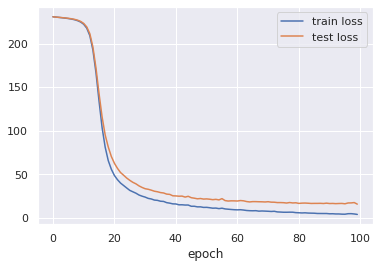

In [96]:
backprop_deep(x_train_torch, y_train_torch, net, T=100)

At first glance, running the function `backprop_deep` for $50-100$ epochs seems to be enough to reach a rather low value
for the running loss.

On the other hand, we notice that the loss only starts decreasing after about $10$ epochs. This is probably due to the low
value of the learning rate ($0.001$). We have tried a learning rate of $0.01$, it allowed us to reach convergence faster
as the loss started decreasing immediately without overshooting.


## Question 16

Analyse the results obtained by applying the network to the testing dataset. 

The results below shows that we have managed to obtain a test accuracy of $\sim 96\%$ with $n = 5000$.

In order to understand how much the value of $n$ (the number of samples in the training set) affects the test
accuracy, we have trained several instances of the network with different values of $n$ (cf function `accuracy_with_n`).

The figure below, shows clearly the importance of using a larger training set.
(the figure is actually inversed, n = f(accuracy) due to a mistake in the code)

In [98]:
pred = net(x_test_torch)
_, pred_labels = pred.max(1)
print("Accuracy: " + str(100 * (y_test_torch == pred_labels).float().mean()))

Accuracy: tensor(96.2600)


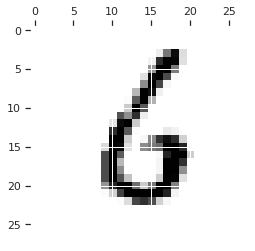

the label of image 42 is 6


In [99]:
x_test_im = x_test.reshape((28, 28, 1, -1))
# let us show image number 50 and its label
MNISTtools.show(x_test_im[:, :, 0, 50])
print("the label of image 42 is", pred_labels[50].item())

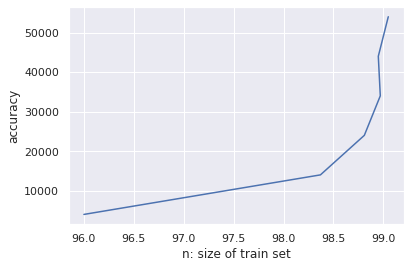

In [124]:
def accuracy_with_n():
    n_values = range(4000, 60000, 10000)
    accu_values = []
    for n in n_values:
        # init
        x_train, y_train = MNISTtools.load(dataset='training')
        x_train = x_train[:,1:n+1]
        y_train = y_train[1:n+1]

        # preprocess
        x_train_im = x_train.reshape((28, 28, 1, -1))
        x_train_im = np.moveaxis(x_train_im, [0, 1, 2], [-1, -2, -3])
        x_train_im = normalize_MNIST_images(x_train_im)
        x_train_torch = torch.from_numpy(x_train_im)
        y_train_torch = torch.from_numpy(y_train)

        # train
        net = LeNet()
        backprop_deep(x_train_torch, y_train_torch, net, gamma=0.01, T=100)

        # predict
        pred = net(x_test_torch)
        _, pred_labels = pred.max(1)
        accu_values.append(100 * (y_test_torch == pred_labels).float().mean())

    #plt.plot(accu_values, n_values)
    plt.plot(n_values, accu_values)
    plt.ylabel("accuracy")
    plt.xlabel("n: size of train set")
    plt.show()

accuracy_with_n()

# PART 5 - Comparison and conclusion

We have applied Kmeans, Naive Bayes, SVM and CNN on the MNIST dataset.
From left to right, we have managed to obtain an increasing test accuracy.

Kmeans in particular doesn't seem to be suitable for this particular classification
problem because the distance (the difference of norm of the images) between the images doesn't
separate the categories into different clusters.

Naive Bayes gave us a test accuracy $\gt 80\%$ which is acceptable if we take into account the low
computing cost. However, from the confusion matrix we can see that many images are missclassified. This is probably
due to the oversimplified model; the independence assumption of the pixels is definitely not realistic.

With SVM we have obtained accuracies higher than $90\%$. $91\%$ when using a linear kernel and $95\%$ when we used
the rbf kernel with optimized hyper-parameters. This shows that the problem is highly non-linear.

Using CNN, we have managed to obtain $96\%$ with only $50$ epochs. We have also managed to reach $99\%$ accuracy
when we trained the network on the whole training set ($n = 60000$).

In conclusion, both SVM (with non-linear kernels) and CNN are suitable to handle this classification problem. CNN in particular allowed
us to reach extremely high accuracies by increasing the number of epochs and the size of the training set.